<a href="https://colab.research.google.com/github/NaveedAhmedShaik/Shaik-Naveed-Ahmed/blob/main/sentiment_analysis_Naveed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
from google.colab import files
uploaded = files.upload()

Saving amazon_reviews.csv to amazon_reviews.csv


In [23]:
#Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
import warnings
import torch

#modeling imports
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


#pre-cnfg
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

#Loading data
file_path = '/content/amazon_reviews.csv'
df = pd.read_csv(file_path)

In [24]:
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.00,No issues.,2014-07-23,138,0,0,0,0,0.00,0.00
1,1,0mie,5.00,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.00,0.00
2,2,1K3,4.00,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.00,0.00
3,3,1m2,5.00,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.00,0.00
4,4,2&amp;1/2Men,5.00,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.00,0.00


In [25]:
df.describe()

,Unnamed: 0,overall,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
count,4915.00,4915.00,4915.00,4915.00,4915.00,4915.00,4915.00,4915.00,4915.00
mean,2457.00,4.59,437.37,1.31,0.21,1.52,1.10,0.08,0.02
std,1418.98,1.00,209.44,41.62,4.02,44.12,39.37,0.26,0.08
min,0.00,1.00,1.00,0.00,0.00,0.00,-130.00,0.00,0.00
25%,1228.50,5.00,281.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,2457.00,5.00,431.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,3685.50,5.00,601.00,0.00,0.00,0.00,0.00,0.00,0.00
max,4914.00,5.00,1064.00,1952.00,183.00,2020.00,1884.00,1.00,0.96


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [27]:
df.isnull().sum()

,0
Unnamed: 0,0
reviewerName,1
overall,0
reviewText,1
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [28]:
df.duplicated().sum()

np.int64(0)

model


In [29]:
df.drop(columns = ["Unnamed: 0"], inplace = True)
df.reset_index(drop = True, inplace = True)

#Tokens
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 3, hidden_dropout_prob=0.3)

#Labels
def assign_label(overall):
    if overall <= 2:
        return 0
    elif overall == 3:
        return 1
    else:
        return 2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
#Labels balance
df["label"] = df['overall'].apply(assign_label)
(df["label"].value_counts()/len(df))*100

,count
label,
2,90.52
0,6.59
1,2.89


Fine-tuning

In [31]:
class_weights = compute_class_weight(class_weight = 'balanced', classes=np.array([0,1,2]), y=df["label"].values)
class_weights = torch.tensor(class_weights, dtype= torch.float)

In [32]:
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len = 200):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [33]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df["reviewText"],df["label"],test_size = 0.20,stratify=df["label"],
                                                                     random_state=77)

train_dataset = ReviewDataset(train_texts.tolist(), train_labels.tolist(), tokenizer)
test_dataset = ReviewDataset(test_texts.tolist(), test_labels.tolist(), tokenizer)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [35]:
#Balance
loss_fn = CrossEntropyLoss(weight=class_weights.to(device))
#Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay = 0.01)

bert


100%|██████████| 123/123 [02:08<00:00,  1.04s/it]


Epoch 1/3, Train Loss: 1.0347
Validation Loss: 0.7140, Accuracy: 0.9013


100%|██████████| 123/123 [02:06<00:00,  1.03s/it]


Epoch 2/3, Train Loss: 0.6998
Validation Loss: 0.7837, Accuracy: 0.8576


100%|██████████| 123/123 [02:07<00:00,  1.03s/it]


Epoch 3/3, Train Loss: 0.5947
Validation Loss: 0.6156, Accuracy: 0.8678


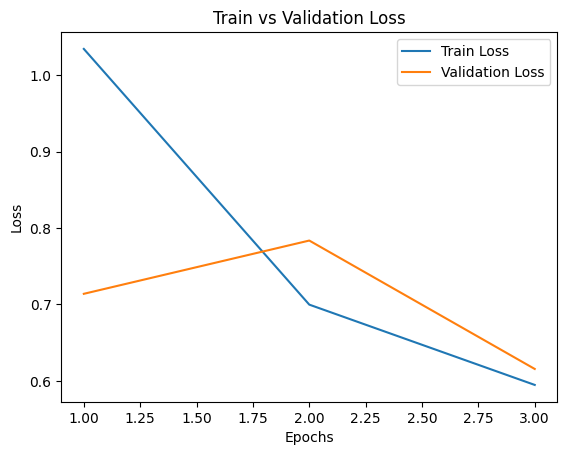

In [36]:
# Evaluation function
def evaluate(model, test_loader):
    model.eval()
    correct_preds = 0
    total_preds = 0
    total_loss = 0  # To keep track of the loss in the validation set
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)  # Calculate the loss

            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    accuracy = correct_preds / total_preds
    avg_loss = total_loss / len(test_loader)
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")
    return avg_loss, accuracy

# Variables to store loss values for plotting
train_losses = []
val_losses = []

# Training
epochs = 3  # Epochs n°
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate at the end of the epoch (on the validation/test set)
    val_loss, accuracy = evaluate(model, test_loader)
    val_losses.append(val_loss)

# Plot train_loss vs val_loss
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

In [37]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

# Get predicctions
true_labels, predictions = get_predictions(model, test_loader)

In [38]:
# Labels
labels = [0, 1, 2]
label_names = ['Something went wrong', 'It was okay', 'Everything went well']

#report
print(classification_report(true_labels, predictions, labels=labels, target_names=label_names))

                      precision    recall  f1-score   support

Something went wrong       0.50      0.94      0.66        65
         It was okay       0.08      0.21      0.12        28
Everything went well       0.99      0.88      0.94       890

            accuracy                           0.87       983
           macro avg       0.53      0.68      0.57       983
        weighted avg       0.94      0.87      0.89       983



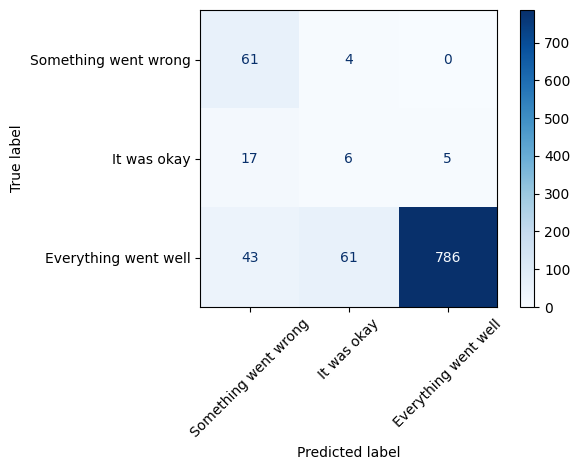

In [39]:
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap='Blues')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()